In [1]:
import os
import json
import pandas as pd

def extract_completion_tokens_for_problem(problem_data, seed_name, experiment_type_raw):
    """
    Extracts problem_id and completion_tokens for the first 5 iterations from a problem's data.
    Uses a specific path for "wait" experiments and a default path for others.

    Args:
        problem_data (dict): The dictionary for a single problem.
        seed_name (str): The name of the seed (e.g., "seed0").
        experiment_type_raw (str): The raw experiment type string (e.g., "backtracking_results").

    Returns:
        dict: A dictionary containing the problem_id, seed, cleaned experiment_type,
              and completion_tokens for each of the first 5 iterations.
              Returns None if problem_data is not a dict or problem_id is missing.
    """
    if not isinstance(problem_data, dict):
        # print(f"Debug: Expected problem_data to be a dict, but got {type(problem_data)}. Skipping.")
        return None

    problem_id = problem_data.get("problem_id")
    if problem_id is None:
        # print(f"Debug: 'problem_id' missing in problem data. Skipping problem.")
        return None

    detailed_metrics = problem_data.get("detailed_metrics", {})

    # Clean up experiment_type
    experiment_type = experiment_type_raw.replace("_results", "")

    token_info = {
        "problem_id": problem_id,
        "seed": seed_name,
        "experiment_type": experiment_type,
    }

    for i in range(5): # Iterations 0 through 4
        iter_key = f"iteration_{i}_completion_tokens"
        token_info[iter_key] = None # Default to None

        if experiment_type == "wait":
            try:
                # For "wait" type, data is in problem_data["iterations"]
                iterations_list = problem_data.get("iterations")
                
                current_iter_data = None
                if isinstance(iterations_list, list):
                    for iter_obj in iterations_list:
                        # iter_obj is a dict, e.g. {"iteration": 0, "prompt": ..., "api_calls": [...]}
                        if isinstance(iter_obj, dict) and iter_obj.get("iteration") == i:
                            current_iter_data = iter_obj
                            break
                
                if current_iter_data:
                    api_calls_list = current_iter_data.get("api_calls")
                    if isinstance(api_calls_list, list) and len(api_calls_list) > 0:
                        last_api_call_obj = api_calls_list[-1] # Get the last dict in the api_calls list
                        
                        if isinstance(last_api_call_obj, dict):
                            # User specified to look for "total_token_usage" key
                            token_usage_dict = last_api_call_obj.get("total_token_usage")
                            
                            if isinstance(token_usage_dict, dict):
                                tokens = token_usage_dict.get("completion_tokens")
                                if tokens is not None:
                                    token_info[iter_key] = tokens
                            # else:
                                # print(f"Debug (wait): 'total_token_usage' key missing or not a dict in last_api_call_obj for problem {problem_id}, iteration {i}")
                        # else:
                            # print(f"Debug (wait): last_api_call_obj is not a dict for problem {problem_id}, iteration {i}")
                    # else:
                        # print(f"Debug (wait): 'api_calls' list missing, not a list, or empty for problem {problem_id}, iteration {i}")
                # else:
                    # print(f"Debug (wait): Data for iteration {i} not found in 'iterations' list for problem {problem_id}")
            except Exception as e: # Catch any error during path traversal
                # print(f"Debug (wait): Error processing problem {problem_id}, iteration {i} (wait type): {e}")
                pass # token_info[iter_key] will remain None
        else:
            # --- Existing logic for other experiment types ---
            iteration_reasoning_key = f'iteration_{i}_reasoning'
            try:
                if detailed_metrics and \
                   iteration_reasoning_key in detailed_metrics and \
                   isinstance(detailed_metrics[iteration_reasoning_key], list) and \
                   len(detailed_metrics[iteration_reasoning_key]) > 0: # Check if list is not empty for [-1]
                    
                    last_reasoning_entry = detailed_metrics[iteration_reasoning_key][-1] # Get the last element
                    
                    if isinstance(last_reasoning_entry, dict) and \
                       'total_token_usage' in last_reasoning_entry and \
                       isinstance(last_reasoning_entry['total_token_usage'], dict) and \
                       'completion_tokens' in last_reasoning_entry['total_token_usage']:
                        
                        tokens = last_reasoning_entry['total_token_usage']['completion_tokens']
                        token_info[iter_key] = tokens
                    # else:
                        # print(f"Debug (non-wait): 'total_token_usage' or 'completion_tokens' missing/malformed in last reasoning for problem {problem_id}, iteration {i}")
                # else:
                    # print(f"Debug (non-wait): '{iteration_reasoning_key}' data not found, not a list, or empty for problem {problem_id}, iteration {i}")
            except (KeyError, IndexError, TypeError) as e:
                # print(f"Debug (non-wait): Error accessing token data for problem {problem_id}, iteration {i}: {e}")
                pass # Keep as None if error

    return token_info



def process_experiment_files_for_tokens(base_directory="."):
    """
    Scans specified directories, processes JSON files, extracts completion tokens,
    and returns a Pandas DataFrame.

    Args:
        base_directory (str): The root directory containing seed_X folders.

    Returns:
        pd.DataFrame: A DataFrame containing aggregated completion token data.
    """
    all_token_results = []
    
    seed_folder_names = [f"seed{i}" for i in range(5)] # seed0 to seed4
    # As per your original script's file structure
    experiment_types_raw = ["backtracking_results", "base_sum_results", "firstk_results", "lastk_results", "postThink_results", "wait", "answer_only"]

    print(f"Scanning base directory: {os.path.abspath(base_directory)}")

    for seed_name in seed_folder_names:
        seed_path = os.path.join(base_directory, seed_name)
        if not os.path.isdir(seed_path):
            print(f"Info: Seed directory not found: {seed_path}. Skipping.")
            continue

        print(f"Processing seed folder: {seed_name}")
        for exp_type_raw in experiment_types_raw:
            expected_filename = f"{seed_name}_{exp_type_raw}.json"
            file_path = os.path.join(seed_path, expected_filename)

            if os.path.isfile(file_path):
                print(f"  Processing file: {expected_filename}")
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data_from_file = json.load(f)
                    
                    if "results" in data_from_file and isinstance(data_from_file["results"], list):
                        problems_in_file = data_from_file["results"]
                        for problem_data_item in problems_in_file:
                            token_data = extract_completion_tokens_for_problem(problem_data_item, seed_name, exp_type_raw)
                            if token_data:
                                all_token_results.append(token_data)
                    else:
                        print(f"  Warning: 'results' key not found or is not a list in {file_path}. Skipping content of this file.")
                        
                except json.JSONDecodeError:
                    print(f"  Error: Could not decode JSON from {file_path}. Skipping file.")
                except Exception as e:
                    print(f"  An unexpected error occurred while processing {file_path}: {e}. Skipping file.")
            else:
                print(f"  Info: Expected file not found: {file_path}. Skipping.")
    
    if not all_token_results:
        print("\nWarning: No token data was processed. Returning an empty DataFrame.")
        return pd.DataFrame()
        
    return pd.DataFrame(all_token_results)

# ... (imports and functions extract_completion_tokens_for_problem, process_experiment_files_for_tokens remain the same) ...

# --- Main Execution ---
# --- Main Execution ---
if __name__ == "__main__":
    TARGET_BASE_DIRECTORY = "/Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results/"
    print(f"Starting token extraction process in base directory: {os.path.abspath(TARGET_BASE_DIRECTORY)}")

    tokens_df = process_experiment_files_for_tokens(base_directory=TARGET_BASE_DIRECTORY)

    if not tokens_df.empty:
        # Ensure all iteration_X_completion_tokens columns are numeric
        for i in range(5):
            col_name = f'iteration_{i}_completion_tokens'
            if col_name in tokens_df.columns:
                 tokens_df[col_name] = pd.to_numeric(tokens_df[col_name], errors='coerce')
            else:
                print(f"Warning: Column {col_name} not found in DataFrame during numeric conversion.")


        print("\n--- DataFrame before filling iteration_0_completion_tokens (sample for seed0, problem 0):")
        if not tokens_df[(tokens_df['problem_id'] == '0') & (tokens_df['seed'] == 'seed0')].empty:
            print(tokens_df[(tokens_df['problem_id'] == '0') & (tokens_df['seed'] == 'seed0')].head(10))
        else:
            print("No data for problem_id '0' and seed 'seed0' to show before fill.")
        
        print("\n--- DataFrame before filling iteration_0_completion_tokens (sample for seed1, problem 0):")
        if not tokens_df[(tokens_df['problem_id'] == '0') & (tokens_df['seed'] == 'seed1')].empty:
            print(tokens_df[(tokens_df['problem_id'] == '0') & (tokens_df['seed'] == 'seed1')].head(10))
        else:
            print("No data for problem_id '0' and seed 'seed1' to show before fill.")


        # --- New Filling Logic for Iteration 0 ---
        print("\nAttempting to fill iteration_0_completion_tokens with new seed-based logic...")

        # Initialize the target column if it's not fully numeric (it should be from above)
        if 'iteration_0_completion_tokens' not in tokens_df.columns:
            tokens_df['iteration_0_completion_tokens'] = pd.NA # Or np.nan
        tokens_df['iteration_0_completion_tokens'] = pd.to_numeric(tokens_df['iteration_0_completion_tokens'], errors='coerce')


        # 1. Create source DataFrame for seed0 (from 'base_sum')
        iter0_source_seed0_df = tokens_df[
            (tokens_df['experiment_type'] == 'base_sum') & 
            (tokens_df['seed'] == 'seed0')
        ][['problem_id', 'seed', 'iteration_0_completion_tokens']].copy()
        iter0_source_seed0_df.rename(columns={'iteration_0_completion_tokens': 'iter0_fill_value'}, inplace=True)
        iter0_source_seed0_df.dropna(subset=['iter0_fill_value'], inplace=True)
        iter0_source_seed0_df.drop_duplicates(subset=['problem_id', 'seed'], keep='first', inplace=True)


        # 2. Create source DataFrame for seeds 1, 2, 3, 4 (from 'backtracking')
        # Assuming seed4 also uses backtracking as source. Adjust if different.
        seeds_for_backtracking_source = ['seed1', 'seed2', 'seed3', 'seed4']
        iter0_source_seeds_other_df = tokens_df[
            (tokens_df['experiment_type'] == 'backtracking') & 
            (tokens_df['seed'].isin(seeds_for_backtracking_source))
        ][['problem_id', 'seed', 'iteration_0_completion_tokens']].copy()
        iter0_source_seeds_other_df.rename(columns={'iteration_0_completion_tokens': 'iter0_fill_value'}, inplace=True)
        iter0_source_seeds_other_df.dropna(subset=['iter0_fill_value'], inplace=True)
        iter0_source_seeds_other_df.drop_duplicates(subset=['problem_id', 'seed'], keep='first', inplace=True)
        
        # 3. Combine the sources
        combined_source_df = pd.concat([iter0_source_seed0_df, iter0_source_seeds_other_df], ignore_index=True)
        combined_source_df.drop_duplicates(subset=['problem_id', 'seed'], keep='first', inplace=True) # Should be unique by problem_id, seed

        # 4. Merge the combined source to the main DataFrame
        tokens_df = pd.merge(tokens_df, combined_source_df, on=['problem_id', 'seed'], how='left', suffixes=('', '_source'))
        
        # 5. Apply the fill based on the seed and whether the original value was NaN
        
        # Condition for seed0: fill if NaN and experiment_type is NOT base_sum
        fill_cond_seed0 = (
            (tokens_df['seed'] == 'seed0') &
            (tokens_df['iteration_0_completion_tokens'].isnull()) &
            (tokens_df['experiment_type'] != 'base_sum') & # Don't overwrite 'base_sum' for seed0 if it was originally NaN
            (tokens_df['iter0_fill_value'].notnull())
        )
        tokens_df.loc[fill_cond_seed0, 'iteration_0_completion_tokens'] = tokens_df.loc[fill_cond_seed0, 'iter0_fill_value']

        # Condition for seeds 1, 2, 3, 4: fill if NaN and experiment_type is NOT backtracking
        fill_cond_seeds_other = (
            (tokens_df['seed'].isin(seeds_for_backtracking_source)) &
            (tokens_df['iteration_0_completion_tokens'].isnull()) &
            (tokens_df['experiment_type'] != 'backtracking') & # Don't overwrite 'backtracking' for these seeds if it was originally NaN
            (tokens_df['iter0_fill_value'].notnull())
        )
        tokens_df.loc[fill_cond_seeds_other, 'iteration_0_completion_tokens'] = tokens_df.loc[fill_cond_seeds_other, 'iter0_fill_value']

        # 6. Drop the temporary merge column
        if 'iter0_fill_value' in tokens_df.columns:
            tokens_df.drop(columns=['iter0_fill_value'], inplace=True)
        
        print("Filling complete with new seed-based logic.")

        print("\n--- DataFrame after filling iteration_0_completion_tokens (sample for seed0, problem 0):")
        if not tokens_df[(tokens_df['problem_id'] == '0') & (tokens_df['seed'] == 'seed0')].empty:
            print(tokens_df[(tokens_df['problem_id'] == '0') & (tokens_df['seed'] == 'seed0')].head(10))
        else:
            print("No data for problem_id '0' and seed 'seed0' to show after fill.")

        print("\n--- DataFrame after filling iteration_0_completion_tokens (sample for seed1, problem 0):")
        if not tokens_df[(tokens_df['problem_id'] == '0') & (tokens_df['seed'] == 'seed1')].empty:
            print(tokens_df[(tokens_df['problem_id'] == '0') & (tokens_df['seed'] == 'seed1')].head(10))
        else:
            print("No data for problem_id '0' and seed 'seed1' to show after fill.")
        # --- End of new filling logic ---

        print("\n--- Aggregated Completion Token Results (First 5 rows) ---")
        print(tokens_df.head())
        
        output_csv_path = os.path.join(TARGET_BASE_DIRECTORY, "aggregated_completion_tokens_by_problem_seed_filled_v2.csv") # New filename
        try:
            tokens_df.to_csv(output_csv_path, index=False)
            print(f"\nToken results saved to: {os.path.abspath(output_csv_path)}")
        except Exception as e:
            print(f"\nError saving CSV to {output_csv_path}: {e}")

        print("\n--- Basic Statistics from Token Data (after new filling) ---")
        if 'problem_id' in tokens_df.columns:
            print(f"Total problem entries processed (rows): {len(tokens_df)}")
            print(f"Unique problem IDs found: {tokens_df['problem_id'].nunique()}")
        if 'seed' in tokens_df.columns:
            print(f"Seeds processed: {sorted(tokens_df['seed'].unique().tolist())}")
        if 'experiment_type' in tokens_df.columns:
            print(f"Experiment types processed: {sorted(tokens_df['experiment_type'].unique().tolist())}")

        if 'iteration_0_completion_tokens' in tokens_df.columns:
            # Ensure the column is numeric again after potential modifications
            numeric_tokens_iter0 = pd.to_numeric(tokens_df['iteration_0_completion_tokens'], errors='coerce')
            if not numeric_tokens_iter0.isnull().all():
                print(f"Overall Average Completion Tokens for Iteration 0 (after new fill): {numeric_tokens_iter0.mean():.2f}")
                print(f"Number of remaining NaN values in iteration_0_completion_tokens: {numeric_tokens_iter0.isnull().sum()}")
                if 'experiment_type' in tokens_df.columns:
                    print("\nAverage Iteration 0 Completion Tokens by Experiment Type (after new fill):")
                    avg_tokens_by_exp = tokens_df.groupby('experiment_type')['iteration_0_completion_tokens'].mean()
                    print(avg_tokens_by_exp)
            else:
                print("No valid numeric data for Iteration 0 completion tokens to calculate average even after new filling.")
    else:
        print("\nNo data was processed to create the token DataFrame.")

    print("\nToken extraction and new filling process finished.")



Starting token extraction process in base directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results
Scanning base directory: /Users/justinshen/Documents/Code/cocolab/reasoning-distillation/paper_results
Processing seed folder: seed0
  Processing file: seed0_backtracking_results.json
  Processing file: seed0_base_sum_results.json
  Processing file: seed0_firstk_results.json
  Processing file: seed0_lastk_results.json
  Processing file: seed0_postThink_results.json
  Processing file: seed0_wait.json
  Processing file: seed0_answer_only.json
Processing seed folder: seed1
  Processing file: seed1_backtracking_results.json
  Processing file: seed1_base_sum_results.json
  Processing file: seed1_firstk_results.json
  Processing file: seed1_lastk_results.json
  Processing file: seed1_postThink_results.json
  Processing file: seed1_wait.json
  Processing file: seed1_answer_only.json
Processing seed folder: seed2
  Processing file: seed2_backtracking_results.json
 

In [3]:
completion_df

NameError: name 'completion_df' is not defined

In [21]:
completion_df = pd.read_csv('aggregated_completion_tokens_by_problem_seed.csv')
completion_df

,problem_id,seed,experiment_type,iteration_0_completion_tokens,iteration_1_completion_tokens,iteration_2_completion_tokens,iteration_3_completion_tokens,iteration_4_completion_tokens
0,0,seed0,backtracking,NaN,3078.0,3092.0,3896.0,3117.0
1,1,seed0,backtracking,NaN,2175.0,2277.0,1952.0,2563.0
2,10,seed0,backtracking,NaN,8192.0,6883.0,5892.0,8192.0
3,11,seed0,backtracking,NaN,8192.0,6597.0,6509.0,8192.0
4,12,seed0,backtracking,NaN,8192.0,8192.0,8192.0,8192.0
...,...,...,...,...,...,...,...,...
1675,5,seed3,answer_only,NaN,8192.0,8192.0,8192.0,6173.0
1676,6,seed3,answer_only,NaN,7677.0,8192.0,8192.0,8192.0
1677,7,seed3,answer_only,NaN,8192.0,8192.0,8192.0,8192.0
1678,8,seed3,answer_only,NaN,7086.0,8192.0,8192.0,6277.0


In [4]:
completion_df2 = pd.read_csv("aggregated_completion_tokens_by_problem_seed_filled_v2.csv")
completion_df2[(completion_df2['seed'] == 'seed0') & (completion_df2['experiment_type'] == 'wait')].head(60)

,problem_id,seed,experiment_type,iteration_0_completion_tokens,iteration_1_completion_tokens,iteration_2_completion_tokens,iteration_3_completion_tokens,iteration_4_completion_tokens
300,0,seed0,wait,4685.0,1798,945,1496,1047
301,1,seed0,wait,2916.0,702,1440,785,754
302,2,seed0,wait,22490.0,389,740,570,237
303,3,seed0,wait,4472.0,1181,1742,1690,1113
304,4,seed0,wait,14677.0,936,862,802,806
305,5,seed0,wait,26645.0,8192,7894,574,8192
306,6,seed0,wait,6401.0,2180,1325,751,661
307,7,seed0,wait,15132.0,365,459,645,1213
308,8,seed0,wait,7391.0,1790,1086,999,930
309,9,seed0,wait,18934.0,351,457,239,192


In [7]:
completion_df2.drop_duplicates()

,problem_id,seed,experiment_type,iteration_0_completion_tokens,iteration_1_completion_tokens,iteration_2_completion_tokens,iteration_3_completion_tokens,iteration_4_completion_tokens
0,0,seed0,backtracking,4685.0,3078,3092,3896,3117
1,1,seed0,backtracking,2916.0,2175,2277,1952,2563
2,10,seed0,backtracking,14605.0,15234,6883,5892,8657
3,11,seed0,backtracking,22273.0,9692,6597,6509,12464
4,12,seed0,backtracking,23767.0,25494,15837,19914,23943
...,...,...,...,...,...,...,...,...
1675,5,seed3,answer_only,5247.0,23636,17069,19526,6173
1676,6,seed3,answer_only,32000.0,7677,9580,11455,9879
1677,7,seed3,answer_only,10927.0,9973,9535,14447,32000
1678,8,seed3,answer_only,9084.0,7086,10511,11572,6277


Successfully loaded aggregated_completion_tokens_by_problem_seed_filled_v2.csv

--- Summary Statistics (Mean ± SEM) ---
iteration_display_label        Iteration 1        Iteration 2        Iteration 3        Iteration 4        Iteration 5
Method                                                                                                                
Answer Only              12438.47 ± 521.66  11839.93 ± 488.61  11821.38 ± 517.14  11672.89 ± 503.48  11939.12 ± 535.31
Backtracking             12438.47 ± 521.66  10609.80 ± 509.23   9036.55 ± 424.25   8444.58 ± 425.09   7979.73 ± 438.79
Base Summary             12438.47 ± 521.66   9596.15 ± 401.03   8427.26 ± 393.72   9116.83 ± 484.48   8246.03 ± 421.15
First-$k$                12438.47 ± 521.66  11517.05 ± 514.59  11451.91 ± 543.41  10740.58 ± 496.92  10849.08 ± 522.41
Last-$k$                 12438.47 ± 521.66   9225.58 ± 439.45   7627.92 ± 372.73   7438.36 ± 417.94   5919.89 ± 320.07
Post-Think               12438.47 ± 521.66   97

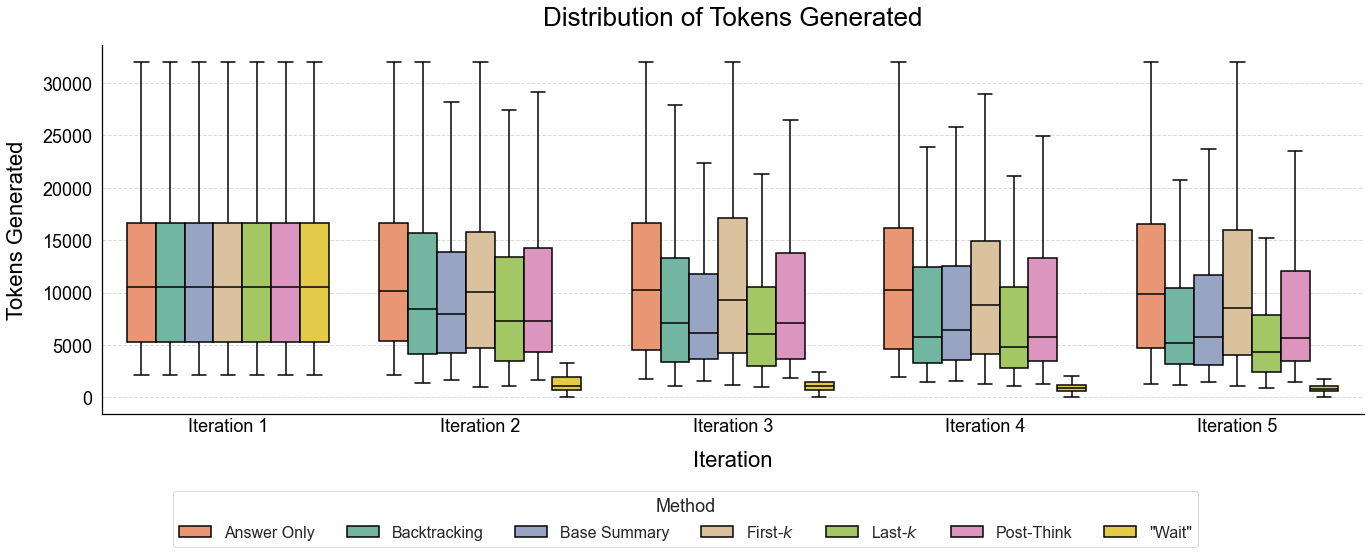

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import numpy as np
import os

# --- Define Mappings and Colors (from your generate_plots.ipynb) ---
METHOD_DISPLAY_NAME_MAP = {
    "backtracking": "Backtracking",
    "base_sum": "Base Summary",
    "firstk": "First-$k$",
    "lastk": "Last-$k$",
    "postThink": "Post-Think",
    "wait": '"Wait"',
    'answer_only': 'Answer Only'
    # Add any other mappings if necessary
}

# Order matters for assigning these colors if used directly as a list.
# It's safer to create a specific map.
RAW_METHOD_NAMES_FOR_COLOR_ORDER = [ # Based on comments in your snippet
    'answer_only',
    'backtracking',
    'base_sum',
    'firstk',
    'lastk',
    'postThink',
    'wait'
]

EXPERIMENTAL_GROUP_COLORS_LIST = [
    '#FC8E62',  # Answer Only
    '#67C0A5',  # Backtracking
    '#8FA1CB',  # Base Summary
    '#E5C495',  # First-$k$
    '#A6D853',  # Last-$k$
    '#E68AC2',  # Post-Think
    '#FEDB2F',  # "Wait"
]

# Create a color map for experiment types
EXPERIMENT_COLOR_MAP = {
    name: EXPERIMENTAL_GROUP_COLORS_LIST[i]
    for i, name in enumerate(RAW_METHOD_NAMES_FOR_COLOR_ORDER)
    if i < len(EXPERIMENTAL_GROUP_COLORS_LIST) # Ensure we don't go out of bounds
}
# Add a default color for any experiment types not in the map, just in case
DEFAULT_COLOR = '#808080' # Grey

def get_display_name(raw_name):
    return METHOD_DISPLAY_NAME_MAP.get(raw_name, raw_name)

def get_method_color(raw_name):
    return EXPERIMENT_COLOR_MAP.get(raw_name, DEFAULT_COLOR)

# --- End Mappings and Colors ---

def create_grouped_boxplot(csv_file_path):
    """
    Creates a grouped box-whisker plot with custom styling and prints summary statistics.
    """
    # 1. Set global font to Avenir
    try:
        plt.rcParams['font.family'] = 'Avenir'
    except RuntimeError:
        print("Avenir font not found. Using default sans-serif font.")
        plt.rcParams['font.family'] = 'sans-serif'
    except Exception as e: # Catch other potential exceptions during font setting
        print(f"An error occurred while setting font 'Avenir': {e}. Using default sans-serif font.")
        plt.rcParams['font.family'] = 'sans-serif'


    try:
        df = pd.read_csv(csv_file_path)
        print(f"Successfully loaded {csv_file_path}")
    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")
        return
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    iteration_token_cols = [f'iteration_{i}_completion_tokens' for i in range(5)]
    missing_cols = [col for col in iteration_token_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Missing token columns: {missing_cols}")
        return

    id_vars_present = [col for col in ['problem_id', 'seed', 'experiment_type'] if col in df.columns]
    if 'experiment_type' not in id_vars_present:
        print("Error: 'experiment_type' column is required and missing.")
        return
        
    df_long = pd.melt(df, 
                        id_vars=id_vars_present, 
                        value_vars=iteration_token_cols,
                        var_name='iteration_label', 
                        value_name='completion_tokens')
    
    df_long['iteration_num_val'] = df_long['iteration_label'].str.extract(r'iteration_(\d+)_completion_tokens').astype(int)
    # 4. Change x-axis labels: Iter 0 -> Iteration 1, etc.
    df_long['iteration_display_label'] = "Iteration " + (df_long['iteration_num_val'] + 1).astype(str)
    
    df_long['completion_tokens'] = pd.to_numeric(df_long['completion_tokens'], errors='coerce')
    df_long.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_long.dropna(subset=['completion_tokens'], inplace=True)

    if df_long.empty:
        print("No data available for plotting or statistics.")
        return
    
    # 5. Print summary statistics (Mean + SEM)
    print("\n--- Summary Statistics (Mean ± SEM) ---")
    summary_stats = df_long.groupby(['experiment_type', 'iteration_display_label'])['completion_tokens'].agg(['mean', 'sem'])
    summary_stats = summary_stats.rename(columns={'mean': 'Mean', 'sem': 'SEM'})
    
    # Format as "Mean ± SEM" string
    summary_stats['Mean ± SEM'] = summary_stats.apply(
        lambda row: f"{row['Mean']:.2f} ± {row['SEM']:.2f}" if pd.notnull(row['SEM']) else f"{row['Mean']:.2f}", 
        axis=1
    )

    # Unstack for table format, using the new display labels
    summary_table = summary_stats['Mean ± SEM'].unstack(level='iteration_display_label')
    
    if not summary_table.empty:
        # Ensure correct column order for the table based on iteration number
        table_iteration_order = sorted(summary_table.columns, key=lambda x: int(x.split(" ")[1]))
        summary_table = summary_table[table_iteration_order]
        
        # Map experiment_type to display names for the table index
        summary_table.index = summary_table.index.map(get_display_name)
        summary_table.index.name = "Method"
        print(summary_table.to_string())
    else:
        print("No data to display in summary statistics table.")
    print("---------------------------------------\n")
    
    # Prepare color palette for seaborn based on the actual experiment types present
    present_experiment_types = sorted(df_long['experiment_type'].unique())
    custom_palette = {exp_type: get_method_color(exp_type) for exp_type in present_experiment_types}


    sns.set_theme(style="whitegrid")
    # Create figure and axes explicitly to easily access the figure object for fig.legend
    fig, ax = plt.subplots(figsize=(20, 8)) 

    # Use the new 'iteration_display_label' for x-axis and ordering
    iteration_order_for_plot = sorted(df_long['iteration_display_label'].unique(), key=lambda x: int(x.split(" ")[1]))
    
    boxplot_line_color = 'black'
    sns.boxplot(ax=ax, # Pass the created axes to seaborn
                x='iteration_display_label', # Use new label for x-axis
                y='completion_tokens', 
                hue='experiment_type',
                data=df_long,
                order=iteration_order_for_plot, # Use sorted new labels
                hue_order=present_experiment_types, 
                palette=custom_palette, 
                # 3. Get rid of the points scattered on the graph (fliers)
                showfliers=False,
                linewidth=1.5,
                # Set edge color for boxes and line colors for whiskers, caps, median
                boxprops={'edgecolor': boxplot_line_color},
                whiskerprops={'color': boxplot_line_color},
                capprops={'color': boxplot_line_color},
                medianprops={'color': boxplot_line_color}
               ) 

    # --- Apply Font Styling and Labels ---
    ax.set_title('Distribution of Tokens Generated', fontsize=26, pad=20, color='black')
    ax.set_xlabel("Iteration", fontsize=22, labelpad=15, color='black')
    ax.set_ylabel('Tokens Generated', fontsize=22, labelpad=15, color='black')
    
    ax.tick_params(axis='x', labelsize=18, colors='black')
    ax.tick_params(axis='y', labelsize=18, colors='black')
    ax.tick_params(axis='x', which='major', length=0) 
    ax.grid(True, linestyle='--', alpha=0.7, axis='y'); ax.grid(False, axis='x') 

    # 2. Get rid of the top and right side / spines of the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Set bottom and left spines to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    # Custom Legend (moved to figure level)
    handles, labels = ax.get_legend_handles_labels()
    if ax.get_legend(): # Remove legend from axes if seaborn created one
        ax.get_legend().remove()
        
    new_labels = [get_display_name(label) for label in labels]
    
    # Add legend to the figure, at the bottom center
    # Legend text color will be dark gray due to sns.set_theme, change if black is needed
    fig.legend(handles, new_labels, 
               title='Method', 
               title_fontsize=18, 
               fontsize=16,       
               loc='upper center', # Anchor point on the legend box
               bbox_to_anchor=(0.5, 0.1), # Position of the anchor point (figure coordinates)
               ncol=len(handles)) 
    
    # Adjust layout to make space for the legend and prevent overlap
    fig.tight_layout(rect=[0.02, 0.1, 0.98, 0.95]) 

    output_plot_filename = "completion_tokens_grouped_boxplot_styled_v2.png" # New filename
    try:
        plt.savefig(output_plot_filename, bbox_inches='tight', dpi=300)
        print(f"\nPlot saved as {os.path.abspath(output_plot_filename)}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    
    # plt.show()

# --- Main execution ---
if __name__ == "__main__":
    csv_file_path = "aggregated_completion_tokens_by_problem_seed_filled_v2.csv" 
    
    if not os.path.exists(csv_file_path):
        print(f"Error: CSV file not found at '{os.path.abspath(csv_file_path)}'.")
    else:
        create_grouped_boxplot(csv_file_path)
